In [318]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.models import resnet34

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score 

from train import group_max, group_argtopk
from dataset import MILdataset

In [319]:
np.set_printoptions(linewidth=150, suppress=True)

## Load model

In [320]:
model = resnet34(num_classes=6)

In [321]:
# load checkpoint
ckpt = '~/Downloads/projects/prostate-cancer-grade-assessment/runs/Jul10_21-36-05_instance-3/checkpoint_best.pt'
model.load_state_dict(torch.load(ckpt, map_location='cpu')['model_state'])
model.eval();

In [322]:
df = pd.read_csv('./data/train.csv').set_index('image_id').sort_index()
df.head()

,data_provider,isup_grade,gleason_score
image_id,,,
0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [323]:
ds = MILdataset('./data/train_images/tiles_overlap_0/', df)
ds.set_mode('eval')
print('dataset length:', len(ds))

Dataset construction mismatch.
dataset length: 500


In [324]:
img_avg = np.loadtxt('./kaggle-datasets/ckpts/img_avg.txt')
img_std  = np.loadtxt('./kaggle-datasets/ckpts/img_std.txt')
ds.transform = T.Compose([T.ToTensor(), T.Normalize(img_avg, img_std)])

In [325]:
idxs_to_eval = np.where(ds.slide_idxs == 5)[0]
idxs_to_eval

array([202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223])

In [326]:
img_id = ds.tiles[idxs_to_eval[0]].rpartition('/')[2].split('_')[0]
label = df.loc[img_id].isup_grade
print('ground truth:\n', df.loc[img_id])

ground truth:
 data_provider    radboud
isup_grade             4
gleason_score        4+4
Name: 07a14fa5b8f74272e4cc0a439dbc8f7f, dtype: object


In [327]:
logits = []
ds.set_mode('eval')
model.eval()
with torch.no_grad():
    for i in idxs_to_eval:
        x = ds[i].unsqueeze(0)
        logits.append(model(x))
logits = torch.cat(logits)

In [328]:
logits.shape

torch.Size([22, 6])

In [329]:
probs = F.softmax(logits, 1).numpy()

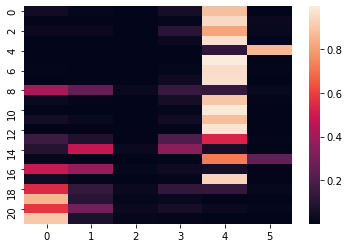

In [330]:
sns.heatmap(probs);

During inference taking:

In [331]:
k = 1
groups = np.zeros(len(probs)).astype(int)
maxs = group_max(probs, groups, k, 0.5)
preds = np.argmax(maxs, 1)
print(maxs)
print('class predicted:', preds)

[[0.0022781  0.00078579 0.0001391  0.00262042 0.12653351 0.86764306]]
class predicted: [5]


In [332]:
# previous method
max_probs = np.argmax(probs, axis=1) + np.max(probs, axis=1)
order = np.lexsort((max_probs, groups))
groups_ordered = groups[order]
probs_ordered = probs[order]
index = np.empty(len(groups), 'bool')
index[-k:] = True
index[:-k] = groups_ordered[k:] != groups_ordered[:-k]
out = np.empty((1, probs.shape[1]))
out[:] = np.nan
out[groups[index]] = probs_ordered[index]
print(out)
print('pred class: ', np.argmax(out, 1))

[[0.0022781  0.00078579 0.0001391  0.00262042 0.12653351 0.86764306]]
pred class:  [5]


During training taking:

In [333]:
topk = group_argtopk(probs, groups, 1)
print('tile selected for training:', topk)
print('probs at selected tile:', probs[topk])

tile selected for training: [4]
probs at selected tile: [[0.0022781  0.00078579 0.0001391  0.00262042 0.12653351 0.86764306]]


In [334]:
# previous method
max_probs = np.argmax(probs, axis=1) + np.max(probs, axis=1)
order = np.lexsort((max_probs, groups))
groups_ordered = groups[order]
probs_ordered = probs[order]
index = np.empty(len(groups), 'bool')
index[-k:] = True
index[:-k] = groups_ordered[k:] != groups_ordered[:-k]
print('tile selected for training:', order[index])
print('probs at selected tile:', probs[order[index]])

tile selected for training: [4]
probs at selected tile: [[0.0022781  0.00078579 0.0001391  0.00262042 0.12653351 0.86764306]]


## GradCAM

In [536]:
conv_features, fc_grads = [], []
fwd_handle = model.layer4.register_forward_hook(lambda m, it, ot: conv_features.append(ot))
bwd_handle = model.layer4.register_backward_hook(lambda m, gin, gout: fc_grads.append(gin))

In [537]:
# select ds tile and class to measure
tile_idx_in_idxs_to_eval = 3
idx = idxs_to_eval[tile_idx_in_idxs_to_eval]
cls_idx = 4
print(f'idx: {idx}, cls_idx: {cls_idx}')
print('predicted probs: ', probs[tile_idx_in_idxs_to_eval])

idx: 205, cls_idx: 4
predicted probs:  [0.00128659 0.00143634 0.0004045  0.02353527 0.96638954 0.00694781]


In [538]:
# run model forward and backward
model.eval()
model.zero_grad()

x = ds[idx]

output = model(x.unsqueeze(0))
print('logits: ', output.detach().numpy())
loss = output[0,cls_idx]
loss.backward()

logits:  [[-2.0408273  -1.9307232  -3.1979318   0.86567533  4.5807424  -0.35439837]]


In [539]:
# compute gradcam
weights = fc_grads[0][0].mean([2,3], keepdim=True)
cam = F.relu(torch.sum(weights * conv_features[0], dim=1, keepdim=True))
cam = F.interpolate(cam, x.shape[1:], mode='bilinear', align_corners=True)
cam = cam.detach().numpy()[0,0]

In [540]:
fwd_handle.remove()
bwd_handle.remove()
model.zero_grad()

In [541]:
print(f'cam range: min = {cam.min()}, max = {cam.max()}')
# renormalize to [0, 1 and weigh by the model probability
cam = (cam - cam.min()) / (cam.max() - cam.min())
print(f'cam range normalized: min = {cam.min()}, max = {cam.max()}')
cls_prob = F.softmax(output, 1)[0,cls_idx].detach().numpy()
cam *= cls_prob
print(f'cam range normalized + prob weighted (cls prob = {cls_prob}): min = {cam.min()}, max = {cam.max()}')

cam range: min = 0.040270525962114334, max = 0.20158635079860687
cam range normalized: min = 0.0, max = 1.0
cam range normalized + prob weighted (cls prob = 0.966389536857605): min = 0.0, max = 0.966389536857605


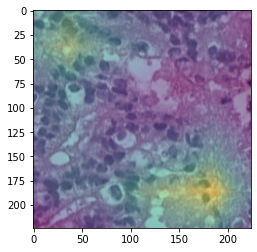

In [542]:
# display
img_transforms = T.Compose([T.Normalize([0,0,0], 1/img_std), T.Normalize(-img_avg, [1,1,1])])
plt.imshow(img_transforms(x).permute(1,2,0).numpy())
plt.imshow(cam, vmin=0, vmax=1, cmap='viridis', alpha=0.5);